# DASC 512 - 24 - Analysis of Variance (ANOVA)

This lessons focuses on **hypothesis tests relating the mean of multiple groups**. We will use the Analysis of Variance (ANOVA) technique to accomplish this.

***


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf   # <--- New package import!

sns.set_style('whitegrid')

Below code generated the images from the slides:

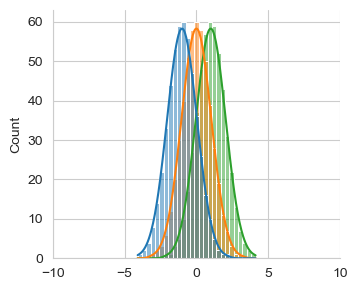

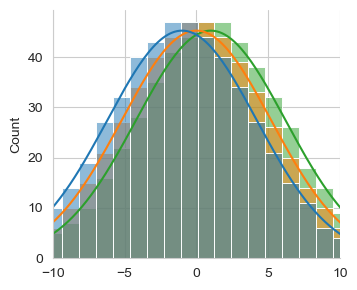

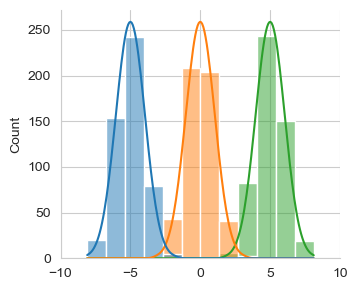

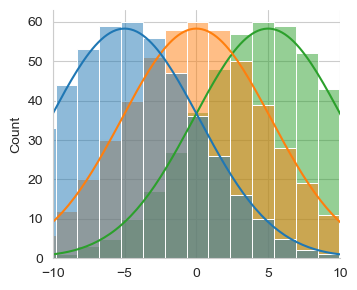

In [2]:
for treat in [1,5]:
    for error in [1,5]:
        group1 = [stats.norm.ppf(q=q, loc=-treat, scale=error) for q in np.linspace(-10,10,10000)]
        group2 = [stats.norm.ppf(q=q, loc=0, scale=error) for q in np.linspace(-10,10,10000)]
        group3 = [stats.norm.ppf(q=q, loc=treat, scale=error) for q in np.linspace(-10,10,10000)]
        df = pd.DataFrame({'Group 1':group1, 'Group 2':group2, 'Group 3':group3})

        fg = sns.displot(data=df, kde=True, aspect=1.2, legend=False, height=3)
        fg.ax.set_xlim(-10,10)
        plt.show()

***

## One-Way ANOVA

### Basic blue/orange example

In [3]:
blue = [1,3]
orange = [2,4]
total = blue + orange

You should always visually examine data first. In this case, it's so basic it's probably unnecessary.

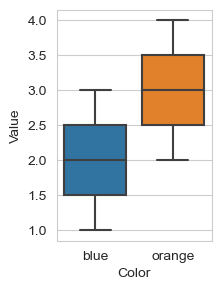

In [4]:
dfbo = pd.DataFrame({'Color':['blue','blue','orange','orange'],'Value':total})
fig, ax = plt.subplots(figsize=(2,3))
sns.boxplot(data=dfbo, x='Color',y='Value', ax=ax)
plt.show()

To perform an ANOVA in Python, we first have to define a model. Make sure that you have imported the statsmodels.formula.api as smf. 

Formulas are communicated using the Patsy language.
* C() specifies that a variable is categorical. For ANOVA, every variable should be categorical.
* Q() specifies it is quantitative. We'll use this for regression in the second half of the course.
* In general, it looks like 'response ~ factor1 + factor2 + factor3 + '...
* We'll dive deeper into Patsy in the second half of the course

In [5]:
model = smf.ols('Value ~ C(Color)', data=dfbo).fit()

In [6]:
anova_table = sms.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Color),1.0,1.0,0.5,0.552786
Residual,4.0,2.0,NaN,NaN


This does not have all the elements of an ANOVA table unfortunately, but it is easy to add MS to the table.

In [7]:
anova_table['mean_sq'] = anova_table['sum_sq'] / anova_table['df']
anova_table = anova_table.reindex(['df','sum_sq','mean_sq','F','PR(>F)'],axis=1)

In [8]:
# May be a good idea to create a function for later use.
def anova(model):
    import statsmodels.stats.api as sms
    at = sms.anova_lm(model, typ=2)
    at['mean_sq'] = at['sum_sq'] / at['df']
    at = at.reindex(['df','sum_sq','mean_sq','F','PR(>F)'],axis=1)
    return at

In [9]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Color),1.0,1.0,1.0,0.5,0.552786
Residual,2.0,4.0,2.0,NaN,NaN


In [10]:
anova(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(Color),1.0,1.0,1.0,0.5,0.552786
Residual,2.0,4.0,2.0,NaN,NaN


And if we want to copy and paste this into Word or Excel for formatting, explore the .to_* functions. .to_clipboard() copies it to your clipboard; just paste in the other software.

In [11]:
anova_table.to_clipboard()

And yes, for two levels this is equivalent to a t-test because t^2=F.

In [12]:
t, pval = stats.ttest_ind(blue, orange)
print(t)
print(t**2)
print(pval)

-0.7071067811865475
0.4999999999999999
0.5527864045000421


### Coughing Kids example

In [13]:
dm = [4,6,9,4,7,7,7,9,12,10,11,6,3,4,9,12,7,6,8,12,12,4,12,13,7,10,13,9,4,4,10,15,9]
honey = [12,11,15,11,10,13,10,4,15,16,9,14,10,6,10,8,11,12,12,8,12,9,11,15,10,1,9,13,8,12,10,8,9,5,12]
placebo = [5,8,6,1,0,8,12,8,7,7,1,6,7,7,12,7,9,7,9,5,11,9,5,6,8,8,6,7,10,9,4,8,7,3,1,4,3]

In [14]:
# Arrange data as a DataFrame for plotting and ANOVAing
labels = ['dm'] * len(dm) + ['honey'] * len(honey) + ['placebo'] * len(placebo)
scores = pd.DataFrame({'treatment':labels, 'score':dm+honey+placebo})

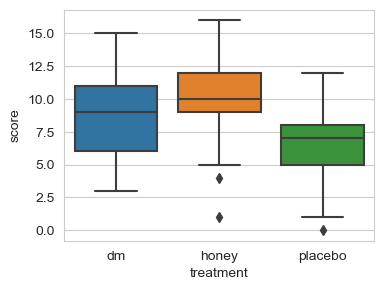

In [15]:
fig, ax = plt.subplots(figsize=(4,3))
sns.boxplot(data=scores, x='treatment',y='score',ax=ax)
plt.show()

In [16]:
model = smf.ols('score ~ C(treatment)', data=scores).fit()
anova_table = anova(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(treatment),2.0,259.842471,129.921236,13.276934,0.000008
Residual,102.0,998.119434,9.785485,NaN,NaN


## Two-Way ANOVA

For an example, let's use some of the built-in data references in Seaborn. Note that this will require that you are connected to the internet. 

For something different, let's look at measurements of various penguins.

Research question: Does species and/or sex of a penguin affect its body mass?

In [17]:
penguins = sns.load_dataset('penguins')

In [18]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [19]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [20]:
penguins[['species','sex']].value_counts()

species    sex   
Adelie     Female    73
           Male      73
Gentoo     Male      61
           Female    58
Chinstrap  Female    34
           Male      34
dtype: int64

Let's start by looking at our data with boxplots.

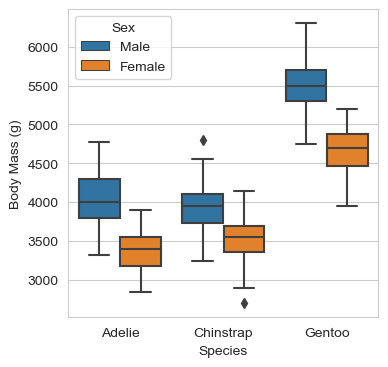

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot(data=penguins, x='species', y='body_mass_g', hue='sex',ax=ax)
ax.legend(title='Sex')
ax.set_xlabel('Species')
ax.set_ylabel('Body Mass (g)')
plt.show()

We can also create interaction plots to look at potential effects and interactions.

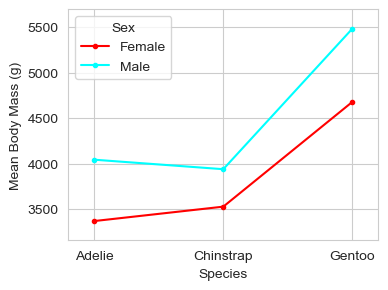

In [28]:
fig, ax = plt.subplots(figsize=(4,3))
smg.interaction_plot(x=penguins['species'], 
                     trace=penguins['sex'], 
                     response=penguins['body_mass_g'],
                     ax=ax)
ax.legend(title='Sex')
ax.set_ylabel('Mean Body Mass (g)')
ax.set_xlabel('Species')
plt.show()

There appears to be a distinct effect of both species and sex on body mass. There is also likely a slight interaction; notice that the sex gap is smaller for chinstrap penguins than the other two species.

That's all speculation though. Let's do our hypothesis test to see.

In [24]:
model = smf.ols('body_mass_g ~ C(species) + C(sex) + C(species):C(sex)', data=penguins).fit()

In [25]:
anova(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(species),2.0,1.434016e+08,7.170079e+07,749.015666,8.144406e-123
C(sex),1.0,3.709026e+07,3.709026e+07,387.459976,1.902273e-57
C(species):C(sex),2.0,1.676557e+06,8.382784e+05,8.756997,1.973489e-04
Residual,327.0,3.130263e+07,9.572669e+04,NaN,NaN


In [26]:
# Equivalent way to specify the model
model = smf.ols('body_mass_g ~ C(species) * C(sex)', data=penguins).fit()
anova_table = anova(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(species),2.0,1.434016e+08,7.170079e+07,749.015666,8.144406e-123
C(sex),1.0,3.709026e+07,3.709026e+07,387.459976,1.902273e-57
C(species):C(sex),2.0,1.676557e+06,8.382784e+05,8.756997,1.973489e-04
Residual,327.0,3.130263e+07,9.572669e+04,NaN,NaN


In [27]:
anova_table.to_clipboard()